In [19]:
from skimage import color, io, measure, img_as_ubyte, util, data, morphology
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, matrix_transform, SimilarityTransform, EuclideanTransform, warp, swirl
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import decomposition
from sklearn.decomposition import PCA
from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray, gray2rgb, rgb2hsv, label2rgb
from skimage.filters import threshold_otsu, prewitt_h, prewitt_v, prewitt, median. gaussian
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening, square
from skimage.segmentation import clear_border
from scipy.stats import norm
from scipy.spatial import distance
import scipy.io as sio
import glob
import os
import SimpleITK as sitk
from IPython.display import clear_output
from sklearn.preprocessing import StandardScaler

1

In [2]:
# Load DICOM file
ds = dicom.dcmread('data/dicom/1-162.dcm')
image = ds.pixel_array

# Load ROI masks
liver_mask = io.imread('data/dicom/LiverROI.png') > 0
kidney_mask = io.imread('data/dicom/KidneyROI.png') > 0
aorta_mask = io.imread('data/dicom/AortaROI.png') > 0

# Extract pixel values for liver, kidney, and aorta
liver_pixels = image[liver_mask]
kidney_pixels = image[kidney_mask]
aorta_pixels = image[aorta_mask]
# Calculate the means of pixel values for each region
mean_liver = np.mean(liver_pixels)
mean_kidney = np.mean(kidney_pixels)
mean_aorta = np.mean(aorta_pixels)

# Calculate thresholds using the mean distance classification
t1 = (mean_liver + mean_kidney) / 2
t2 = (mean_kidney + mean_aorta) / 2

print("Threshold t1 (Liver-Kidney):", t1)
print("Threshold t2 (Kidney-Aorta):", t2)
# Determine thresholds using minimum distance classification
t1 = (np.mean(liver_pixels) + np.mean(kidney_pixels)) / 2
t2 = (np.mean(kidney_pixels) + np.mean(aorta_pixels)) / 2

# Segment the image
segmented = np.logical_and(image > t1, image < t2)

# Compute DICE Score
def dice_coefficient(truth, pred):
    truth = np.asarray(truth).astype(bool)
    pred = np.asarray(pred).astype(bool)

    intersection = np.logical_and(truth, pred).sum()
    return 2. * intersection / (truth.sum() + pred.sum())

dice_score = dice_coefficient(kidney_mask, segmented)

print("Threshold t1:", t1)
print("Threshold t2:", t2)
print("DICE Score:", dice_score)

Threshold t1 (Liver-Kidney): 135.53619417264818
Threshold t2 (Kidney-Aorta): 196.7035801627044
Threshold t1: 135.53619417264818
Threshold t2: 196.7035801627044
DICE Score: 0.24143337066069429


2

In [3]:
# Data points
points = [(7, 13), (9, 10), (6, 10), (6, 8), (3, 6)]

# Convert degrees to radians
theta = np.deg2rad(151)

# Calculate rho for each point
calculated_rhos = [x * np.cos(theta) + y * np.sin(theta) for x, y in points]

# Find which points correspond to rho = 0.29
threshold = 0.1  # Define a threshold for floating point comparison
matching_points = [points[i] for i, rho in enumerate(calculated_rhos) if abs(rho - 0.29) < threshold]

print("Matching points:", matching_points)

Matching points: [(3, 6)]


3

In [4]:
matrix = np.array([[64,94,21,19,31],
                   [38,88,30,23,92],
                   [81,55,47,17,43],
                   [53,62,23,23,18],
                   [35,59,84,44,90]])

# Initialize the accumulator matrix with the same shape as the input matrix
accumulator = np.zeros_like(matrix)
accumulator[0] = matrix[0]

# Dynamic programming to fill the accumulator matrix
for i in range(1, len(matrix)):
    for j in range(len(matrix[i])):
        # Values from the cell directly above, left-above and right-above
        above = accumulator[i-1, j]
        left_above = accumulator[i-1, j-1] if j > 0 else np.inf
        right_above = accumulator[i-1, j+1] if j < len(matrix[i]) - 1 else np.inf
        
        # Current cell cost plus the minimum of the possible previous cells
        accumulator[i, j] = matrix[i, j] + min(above, left_above, right_above)

# Output the minimum value in the last row of the accumulator matrix
min_path_cost = np.min(accumulator[-1])
print(f"The minimal value of the last row of the computed accumulator image is: {min_path_cost}")

The minimal value of the last row of the computed accumulator image is: 121


4

In [5]:
matrix = np.array([[168,217,178,60,97,136],
                   [159,223,155,252,32,108]])

# Splitting the matrix into three parts: white1, black, white2
white1 = matrix[:, 0:2]  # first two columns
black = matrix[:, 2:4]   # middle two columns
white2 = matrix[:, 4:6]  # last two columns

# Calculate the sum of each area
sum_white1 = np.sum(white1)
sum_black = np.sum(black)
sum_white2 = np.sum(white2)

# Calculate the Haar feature value
haar_feature_value = (sum_white1 + sum_white2) - sum_black

print("Sum of the first white area:", sum_white1)
print("Sum of the black area:", sum_black)
print("Sum of the second white area:", sum_white2)
print("Haar feature value:", haar_feature_value)

Sum of the first white area: 767
Sum of the black area: 645
Sum of the second white area: 373
Haar feature value: 495


5

In [6]:
matrix = np.array([[33,12,110,122,204,218,25,231],
                   [200,53,81,187,145,135,221,169],
                   [220,120,107,6,39,12,108,201],
                   [114,168,217,178,60,97,136,16],
                   [253,159,223,155,252,32,108,86],
                   [131,68,68,69,129,244,174,119],
                   [93,51,93,122,44,105,71,112],
                   [75,149,45,233,24,64,146,56]])

# Compute the integral image
integral_image = np.zeros_like(matrix)
integral_image[0, 0] = matrix[0, 0]

for x in range(1, matrix.shape[0]):
    integral_image[x, 0] = integral_image[x-1, 0] + matrix[x, 0]

for y in range(1, matrix.shape[1]):
    integral_image[0, y] = integral_image[0, y-1] + matrix[0, y]

for x in range(1, matrix.shape[0]):
    for y in range(1, matrix.shape[1]):
        integral_image[x, y] = matrix[x, y] + integral_image[x-1, y] + integral_image[x, y-1] - integral_image[x-1, y-1]

# The value at position (2, 2)
print("Integral image value at (2, 2):", integral_image[2, 2])

Integral image value at (2, 2): 936


6

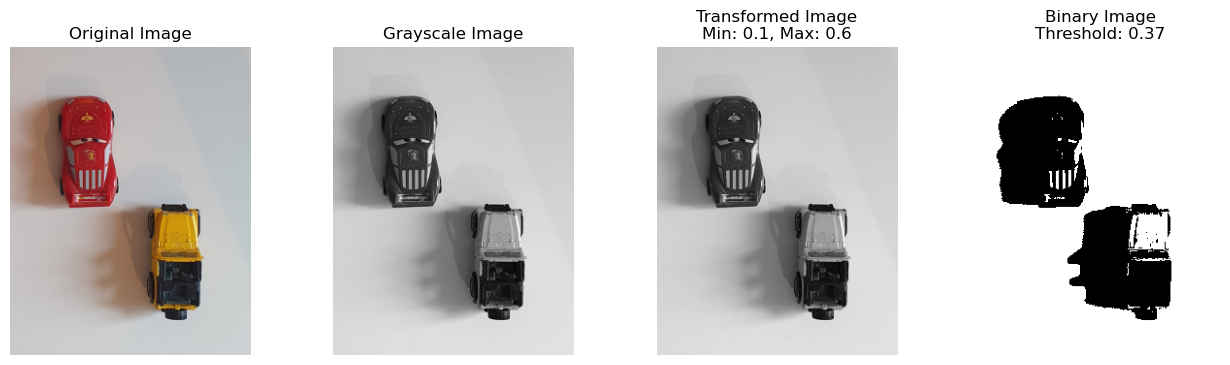

0.3724609375


In [8]:


# Load the image
image = io.imread('data/PixelWiseOps/pixelwise.png')

# Convert to grayscale
gray_image = color.rgb2gray(image)

# Normalize gray image to be in the range 0.1 to 0.6
normalized_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
transformed_image = 0.1 + normalized_image * (0.6 - 0.1)

# Compute Otsu's threshold
threshold = threshold_otsu(transformed_image)

# Apply threshold
binary_image = transformed_image > threshold

# Display the results
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(gray_image, cmap='gray')
ax[1].set_title('Grayscale Image')
ax[1].axis('off')

ax[2].imshow(transformed_image, cmap='gray')
ax[2].set_title(f'Transformed Image\nMin: 0.1, Max: 0.6')
ax[2].axis('off')

ax[3].imshow(binary_image, cmap='gray')
ax[3].set_title(f'Binary Image\nThreshold: {threshold:.2f}')
ax[3].axis('off')

plt.show()

print(threshold)

7

In [9]:
# Training data
cows = np.array([26, 46, 33, 23, 35, 28, 21, 30, 38, 43])
sheep = np.array([67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100])

# Calculate means
mean_cows = np.mean(cows)
mean_sheep = np.mean(sheep)

# Calculate threshold
threshold = (mean_cows + mean_sheep) / 2

print("Mean intensity for cows:", mean_cows)
print("Mean intensity for sheep:", mean_sheep)
print("Threshold intensity:", threshold)

Mean intensity for cows: 32.3
Mean intensity for sheep: 50.166666666666664
Threshold intensity: 41.233333333333334


8

In [10]:
mean_cows = np.mean([26, 46, 33, 23, 35, 28, 21, 30, 38, 43])
std_cows = np.std([26, 46, 33, 23, 35, 28, 21, 30, 38, 43])

mean_sheep = np.mean([67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100])
std_sheep = np.std([67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100])

# Gaussian function defined previously
def gaussian(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

# Value at which we want to evaluate the Gaussians
x_value = 38

# Calculate the Gaussian values
gaussian_value_cows = gaussian(x_value, mean_cows, std_cows)
gaussian_value_sheep = gaussian(x_value, mean_sheep, std_sheep)

print("Gaussian value for cows at x=38:", gaussian_value_cows)
print("Gaussian value for sheep at x=38:", gaussian_value_sheep)

Gaussian value for cows at x=38: 0.03898570495862376
Gaussian value for sheep at x=38: 0.016687527843330045


9

In [13]:
# Load and display the original image
image = io.imread('data/BLOBs/figures.png')

# Convert to grayscale
gray_image = color.rgb2gray(image)

# Otsu's thresholding
threshold = threshold_otsu(gray_image)
binary_image = gray_image < threshold  # foreground is less than the threshold

# Remove objects touching the border
cleared_image = morphology.remove_small_objects(morphology.remove_small_holes(binary_image), connectivity=1)
cleared_image = clear_border(cleared_image)

# Label the image
label_image = measure.label(cleared_image)
properties = measure.regionprops(label_image)

# Calculate area and perimeter of each blob
areas = [prop.area for prop in properties]
perimeters = [prop.perimeter for prop in properties]

# Find BLOBs with area greater than 13000 pixels
large_blobs = [area for area in areas if area > 13000]

# Print results
print("Areas of detected BLOBs:", areas)
print("Perimeters of detected BLOBs:", perimeters)
print(f"Number of BLOBs with area greater than 13000 pixels: {len(large_blobs)}")

# Display area and perimeter
print("Areas of detected BLOBs:", areas)
print("Perimeters of detected BLOBs:", perimeters)

# Counting the BLOBs
print("Number of mini figures detected:", len(properties))

Areas of detected BLOBs: [15145.0, 1017.0, 16829.0, 10666.0, 10584.0, 28234.0, 11850.0, 906.0]
Perimeters of detected BLOBs: [969.9453095790604, 222.69343417595164, 1781.6519830843586, 1046.8326112068523, 1026.697618258058, 1235.1940469205895, 683.9909447527599, 236.00104602052653]
Number of BLOBs with area greater than 13000 pixels: 3
Areas of detected BLOBs: [15145.0, 1017.0, 16829.0, 10666.0, 10584.0, 28234.0, 11850.0, 906.0]
Perimeters of detected BLOBs: [969.9453095790604, 222.69343417595164, 1781.6519830843586, 1046.8326112068523, 1026.697618258058, 1235.1940469205895, 683.9909447527599, 236.00104602052653]
Number of mini figures detected: 8


10

Largest BLOB Area: 27828.0
Largest BLOB Perimeter: 1998.35761056913


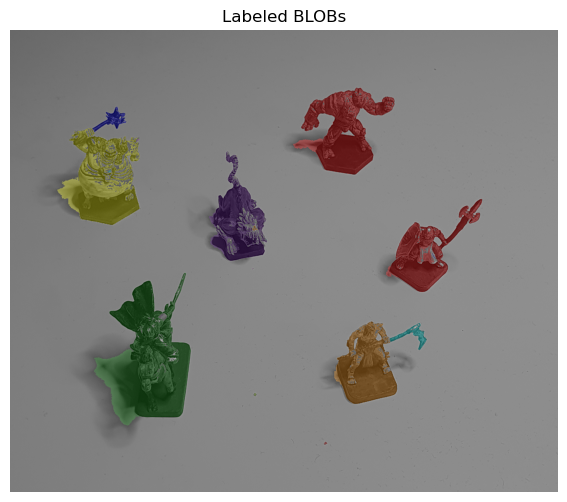

In [16]:
gray_image = color.rgb2gray(image)

# Step 2: Apply Otsu's threshold
threshold = threshold_otsu(gray_image)
binary_image = gray_image < threshold

# Step 3: Remove BLOBs connected to the edges
cleared_image = clear_border(binary_image)

# Step 4: Label the image
label_image = measure.label(cleared_image)

# Step 5: Calculate properties of each BLOB
regions = measure.regionprops(label_image)

# Step 6: Find the BLOB with the largest area and its perimeter
if regions:
    largest_blob = max(regions, key=lambda x: x.area)
    largest_area = largest_blob.area
    largest_perimeter = largest_blob.perimeter
    print(f"Largest BLOB Area: {largest_area}")
    print(f"Largest BLOB Perimeter: {largest_perimeter}")
else:
    print("No BLOBs found")

# Optional: Show the labeled image
plt.figure(figsize=(10, 6))
plt.imshow(label2rgb(label_image, image=gray_image, bg_label=0))
plt.title('Labeled BLOBs')
plt.axis('off')
plt.show()

11

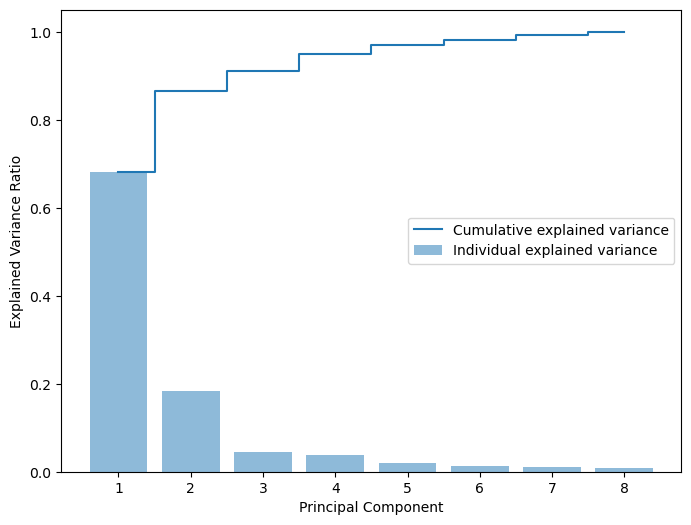

Explained Variance Ratios per Principal Component:
 [0.68205515 0.18346785 0.04572931 0.03789944 0.0196682  0.01256003
 0.01081667 0.00780335]


In [21]:
df = np.loadtxt('data/CarPCA/car_data.txt', comments = '%')

# Step 1: Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

# Step 2: Perform PCA
pca = PCA()
principal_components = pca.fit_transform(normalized_data)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative variance explains
cumulative_variance = explained_variance.cumsum()

# Plotting Explained Variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.legend(loc='best')
plt.show()

# Print results
print("Explained Variance Ratios per Principal Component:\n", explained_variance)


12

In [22]:

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(df)

# Access the first element after mean subtraction and normalization
first_element = normalized_data[0, 0]
print("The value at row=0, col=0 after mean subtraction and normalization is:", first_element)

The value at row=0, col=0 after mean subtraction and normalization is: -1.6884672145358337


13

In [24]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

# Initialize PCA
pca = PCA()

# Fit PCA on the normalized data
pca.fit(normalized_data)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the total variation explained by the first two principal components
total_variation_two_components = explained_variance_ratio[0] + explained_variance_ratio[1]

print("Explained variance ratio by the first component:", explained_variance_ratio[0])
print("Explained variance ratio by the second component:", explained_variance_ratio[1])
print("Total variation explained by the first two principal components:", total_variation_two_components)

Explained variance ratio by the first component: 0.682055150874965
Explained variance ratio by the second component: 0.18346785117832148
Total variation explained by the first two principal components: 0.8655230020532865


14

In [25]:
# Initialize and fit StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

# Initialize PCA
pca = PCA()

# Fit PCA on the normalized data
pca.fit(normalized_data)

# Project data onto PCA space
projected_data = pca.transform(normalized_data)

# Get the first coordinate of the first car
first_coordinate_first_car = projected_data[0, 0]

# Compute the absolute value
absolute_first_coordinate = abs(first_coordinate_first_car)

print("The first coordinate of the first car in PCA space:", first_coordinate_first_car)
print("Absolute value of the first coordinate of the first car in PCA space:", absolute_first_coordinate)

The first coordinate of the first car in PCA space: -1.1282393391042853
Absolute value of the first coordinate of the first car in PCA space: 1.1282393391042853


15

c:\Users\Leuro\anaconda3\envs\Image_Analysis\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Leuro\anaconda3\envs\Image_Analysis\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Leuro\anaconda3\envs\Image_Analysis\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Leuro\anaconda3\envs\Image_Analysis\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

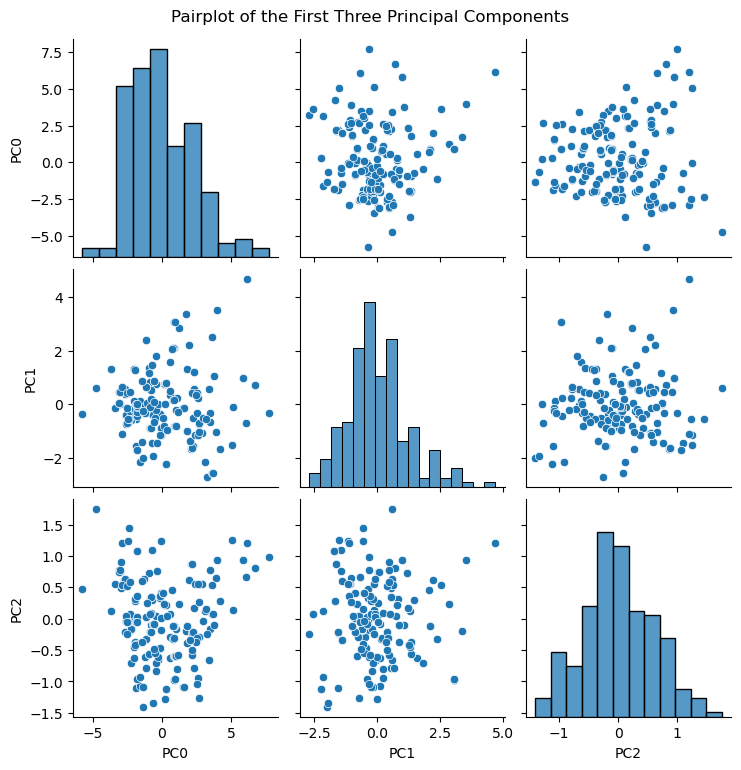

In [29]:
df_pca = pd.DataFrame(projected_data[:, :3], columns=['PC0', 'PC1', 'PC2'])

# Create pairplot of the first three principal components
pairplot = sns.pairplot(df_pca)
plt.suptitle('Pairplot of the First Three Principal Components', y=1.02)  # adjust the title placement
plt.show()

16

Initial alignment error F: 67021.0
Final alignment error F: 21119.638667058513
The pixel value at (150, 150) in the warped image is: [129 129 129]


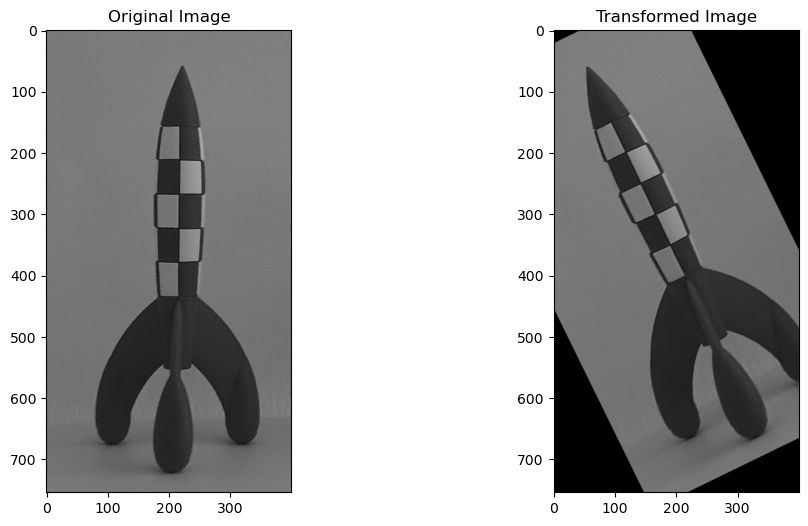

In [30]:
# Load your image
image = io.imread('data/GeomTrans/rocket.png')

# Define landmarks
source_landmarks = np.array([[220, 55], [105, 675], [315, 675]])
destination_landmarks = np.array([[100, 165], [200, 605], [379, 525]])

# Function to compute the sum of squared Euclidean distances
def calculate_F(a, b):
    return np.sum(np.linalg.norm(a - b, axis=1)**2)

# Compute initial F
initial_F = calculate_F(source_landmarks, destination_landmarks)
print("Initial alignment error F:", initial_F)

# Compute the Euclidean transform
tform = EuclideanTransform()
tform.estimate(source_landmarks, destination_landmarks)

# Apply transformation to the source landmarks to check new alignment
transformed_landmarks = tform(source_landmarks)

# Compute F after transformation
final_F = calculate_F(transformed_landmarks, destination_landmarks)
print("Final alignment error F:", final_F)

# Apply the transformation to the whole image
warped_image = warp(image, inverse_map=tform.inverse, output_shape=image.shape)

# Convert the warped image to bytes
warped_image_bytes = img_as_ubyte(warped_image)
# Get the pixel value at row 150, column 150
pixel_value = warped_image_bytes[150, 150]

# Print the pixel value
print(f"The pixel value at (150, 150) in the warped image is: {pixel_value}")
# Display images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[1].imshow(warped_image_bytes, cmap='gray')
ax[1].set_title('Transformed Image')
plt.show()

17

In [34]:
# Apply Gaussian filter with sigma=3
from skimage.filters import gaussian
image = io.imread('data/GeomTrans/rocket.png', as_gray=True)  # Load as grayscale if it's a color image

# Apply Gaussian filter
sigma = 3
filtered_image = gaussian(image, sigma=sigma)

# Convert the filtered image to a byte image
byte_image = img_as_ubyte(filtered_image)

# Access the pixel value at row=100, column=100
pixel_value = byte_image[100, 100]
print("The value of the pixel at (row=100, column=100) is:", pixel_value)

The value of the pixel at (row=100, column=100) is: 123


18

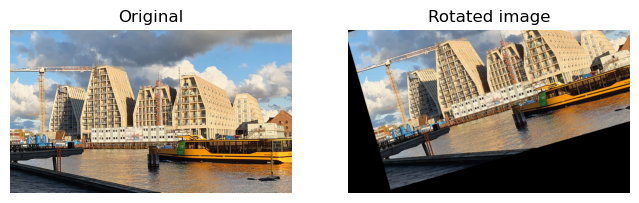

The value of the pixel at (row=200, column=200) is: [88 91 95]


In [40]:
# Load the image
image = io.imread('data/GeomTrans/CPHSun.png')

# Rotate the image
rotation_angle = 16  # degrees
rotation_center = (20, 20)  # coordinates
rotated_image = rotate(image, rotation_angle, center=rotation_center)

def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(transformed)
    ax2.set_title(transformed_name)
    ax2.axis('off')
    io.show()
show_comparison(image, rotated_image, "Rotated image")
# Convert the rotated image to a byte image
byte_image = img_as_ubyte(rotated_image)

# Access the pixel value at row=200, column=200
pixel_value = byte_image[200, 200]
print("The value of the pixel at (row=200, column=200) is:", pixel_value)

19

In [41]:
image = io.imread('data/PixelWiseOps/pixelwise.png')
# Convert the image from RGB to HSV
image_hsv = color.rgb2hsv(image)

# Extract the S component
s_image = image_hsv[:, :, 1]

# Compute Otsu's threshold on the S component
threshold_value = threshold_otsu(s_image)

# Create a binary image where pixels above the threshold are set to foreground
binary_image = s_image > threshold_value

# Perform morphological erosion with a disk-shaped structuring element
selem = disk(4)
eroded_image = morphology.erosion(binary_image, selem)

# Count the number of foreground pixels in the eroded image
foreground_pixels = np.sum(eroded_image)

print("Number of foreground pixels in the resulting image:", foreground_pixels)

Number of foreground pixels in the resulting image: 10045


20

In [42]:
image1 = io.imread('data/ChangeDetection/change1.png')
image2 = io.imread('data/ChangeDetection/change2.png')
# Convert to grayscale
gray1 = color.rgb2gray(image1)
gray2 = color.rgb2gray(image2)

# Compute the absolute difference
difference_image = np.abs(gray1 - gray2)

# Identify changed pixels (value > 0.3)
changed_pixels = np.sum(difference_image > 0.3)

# Total number of pixels
total_pixels = np.product(difference_image.shape)

# Percentage of changed pixels
percentage_changed = (changed_pixels / total_pixels) * 100

print("Percentage of changed pixels:", percentage_changed)

Percentage of changed pixels: 4.560539752005835


21

22